# Phenotype prediction for all individuals

In [41]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

import admix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import seaborn as sns
import admix_prs
import statsmodels.api as sm
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [42]:
prefix = "hsq-0.25-pcausal-0.01-hermodel-gcta"
ldpred2_dir = f"out/ldpred2/{prefix}"
PLINK_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/admix-prs-uncertainty/data/PLINK/"

In [43]:
group_list = ["eur_test", "admix"]
bfile_list = [join(PLINK_DIR, group, "merged") for group in group_list]

In [44]:
def submit_predict(prefix, sim_i):
    ldpred2_dir = f"out/ldpred2/{prefix}"
    df_weights = (
        pd.read_csv(join(ldpred2_dir, f"sim_{sim_i}.weight.tsv.gz"), sep="\t")
        .rename(columns={"CHR": "CHROM", "A1": "REF", "A2": "ALT"})
        .set_index("SNP")
    )
    for group, bfile in zip(group_list, bfile_list):
        df_pred = admix_prs.calc_prs(bfile, df_weights)
        df_pred.to_csv(join(ldpred2_dir, f"sim_{sim_i}.prs.{group}.tsv.gz"), sep="\t")


import submitit

executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=70,
    memory_g=20,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_predict, [prefix] * 10, np.arange(10))

In [4]:
def summarize(prefix, sim_i, quantiles=[0.1, 0.9], seed=1234):
    np.random.seed(seed)

    # read PRS
    df_prs_eur_test = pd.read_csv(
        f"out/ldpred2/{prefix}/sim_{sim_i}.prs.eur_test.tsv.gz", sep="\t", index_col=0
    )
    df_prs_admix = pd.read_csv(
        f"out/ldpred2/{prefix}/sim_{sim_i}.prs.admix.tsv.gz", sep="\t", index_col=0
    )
    df_prs = pd.concat([df_prs_eur_test, df_prs_admix])

    # read genetic value and phenotype
    df_pheno_g = (
        pd.read_csv(join(f"out/pheno/{prefix}/sim.pheno_g.tsv"), sep="\t", index_col=0)[
            ["GROUP", f"SIM_{sim_i}"]
        ]
        .rename(columns={f"SIM_{sim_i}": "GV"})
        .reindex(df_prs.index)
    )
    df_pheno = (
        pd.read_csv(join(f"out/pheno/{prefix}/sim.pheno.tsv"), sep="\t", index_col=0)[
            [f"SIM_{sim_i}"]
        ]
        .rename(columns={f"SIM_{sim_i}": "PHENO"})
        .reindex(df_prs.index)
    )

    df_prs = pd.concat([df_pheno, df_pheno_g, df_prs], axis=1)

    # predict in phenotype space
    df_pred = df_prs[[f"SAMPLE_{i}" for i in range(1, 501)]]
    #     df_pred += np.random.normal(scale=np.sqrt(1 - hsq), size=df_pred.shape)

    pred_sd = np.std(df_pred, axis=1)
    df_plot = pd.DataFrame(
        {
            "PRS_MEAN": df_prs["MEAN"],
            "PRS_SD": pred_sd,
            "GV": df_prs["GV"],
            "GROUP": df_prs["GROUP"],
            "PHENO": df_prs["PHENO"],
        }
    )
    pred_interval = np.quantile(df_pred, q=quantiles, axis=1)
    for q_i, q in enumerate(quantiles):
        df_plot[f"PRS_Q_{q}"] = pred_interval[q_i, :]

    return df_plot

In [5]:
# read local ancestry
df_lanc = pd.read_csv("out/admix_lanc.tsv", sep="\t", index_col=0)
df_lanc["lanc"] = 1.0 - df_lanc["lanc"]
df_lanc["lanc_q"] = pd.qcut(df_lanc.lanc, q=5).cat.codes + 1

# read phenotype
PHENO_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/admix-prs-uncertainty/data/pheno"
df_covar = (
    pd.concat(
        [
            pd.read_csv(join(PHENO_DIR, f"{group}.covar"), delim_whitespace=True)
            for group in ["eur_test", "admix"]
        ]
    )
    .reset_index(drop=True)
    .astype({"FID": str, "IID": str})
)
df_covar.index = df_covar.FID + "_" + df_covar.IID
df_covar = df_covar[["SEX", "AGE"] + [f"PC{i}" for i in range(1, 11)]]

In [13]:
from scipy.stats import pearsonr

In [39]:
df_tmp = df_summary[df_summary.GROUP == "eur_test"]

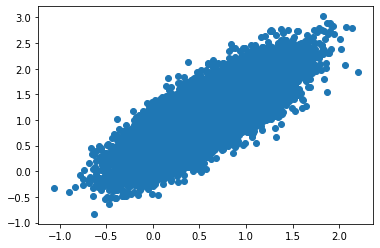

In [50]:
plt.scatter(df_tmp.PRS_MEAN, df_tmp.GV)

In [48]:
df_tmp

,PRS_MEAN,PRS_SD,GV,GROUP,PHENO,PRS_Q_0.1,PRS_Q_0.9
indiv,,,,,,,
1000102_1000102,0.424966,0.397050,1.235614,eur_test,0.609090,-0.065730,0.955979
1000774_1000774,0.338558,0.369597,0.352794,eur_test,-0.570164,-0.133382,0.812199
1000807_1000807,0.739521,0.403665,1.157441,eur_test,1.017841,0.252306,1.230806
1001523_1001523,0.989213,0.399081,1.343490,eur_test,1.366013,0.451934,1.505497
1001531_1001531,0.547188,0.376795,0.977061,eur_test,1.198312,0.049711,1.028231
...,...,...,...,...,...,...,...
6024190_6024190,0.881526,0.388144,1.508445,eur_test,0.981166,0.396357,1.419201
6024532_6024532,0.726487,0.381413,1.343304,eur_test,1.424069,0.229938,1.229401
6025446_6025446,0.768674,0.385219,0.964269,eur_test,0.953745,0.262479,1.251622


In [40]:
pearsonr(df_tmp.PRS_MEAN, df_tmp.GV)[0] ** 2

0.6443133957287928

In [45]:
df_tmp.PRS_MEAN.var()

0.1606290762293977

In [47]:
var_g

0.24667967475005917

In [46]:
var_u

0.154057833005201

In [33]:
var_g = df_tmp.GV.var()
var_u = np.square(df_tmp.PRS_SD).mean()

In [34]:
r2 = (var_g - var_u) / var_g

In [37]:
r2

0.3754741522125991

In [36]:
1 - r2

0.624525847787401

In [21]:
df_tmp["P"]

,PRS_MEAN,PRS_SD,GV,GROUP,PHENO,PRS_Q_0.1,PRS_Q_0.9
indiv,,,,,,,
1000102_1000102,0.424966,0.397050,1.235614,eur_test,0.609090,-0.065730,0.955979
1000774_1000774,0.338558,0.369597,0.352794,eur_test,-0.570164,-0.133382,0.812199
1000807_1000807,0.739521,0.403665,1.157441,eur_test,1.017841,0.252306,1.230806
1001523_1001523,0.989213,0.399081,1.343490,eur_test,1.366013,0.451934,1.505497
1001531_1001531,0.547188,0.376795,0.977061,eur_test,1.198312,0.049711,1.028231
...,...,...,...,...,...,...,...
6024190_6024190,0.881526,0.388144,1.508445,eur_test,0.981166,0.396357,1.419201
6024532_6024532,0.726487,0.381413,1.343304,eur_test,1.424069,0.229938,1.229401
6025446_6025446,0.768674,0.385219,0.964269,eur_test,0.953745,0.262479,1.251622


In [12]:
df_summary

,PRS_MEAN,PRS_SD,GV,GROUP,PHENO,PRS_Q_0.1,PRS_Q_0.9
indiv,,,,,,,
1000102_1000102,0.424966,0.397050,1.235614,eur_test,0.609090,-0.065730,0.955979
1000774_1000774,0.338558,0.369597,0.352794,eur_test,-0.570164,-0.133382,0.812199
1000807_1000807,0.739521,0.403665,1.157441,eur_test,1.017841,0.252306,1.230806
1001523_1001523,0.989213,0.399081,1.343490,eur_test,1.366013,0.451934,1.505497
1001531_1001531,0.547188,0.376795,0.977061,eur_test,1.198312,0.049711,1.028231
...,...,...,...,...,...,...,...
6022871_6022871,0.354871,0.486432,0.255388,admix_5,0.269944,-0.278249,0.950168
6023479_6023479,0.917496,0.470832,0.874967,admix_3,1.561598,0.301201,1.539313
6024954_6024954,0.723621,0.434092,1.106470,admix_3,2.039807,0.179635,1.275775


In [11]:
prefix = "hsq-0.25-pcausal-0.01-hermodel-uniform"
for sim_i in range(10):
    df_summary = summarize(prefix, sim_i)
    df_summary.loc[df_lanc.index, "GROUP"] = "admix_" + df_lanc["lanc_q"].astype(str)
    df_summary.to_csv(f"./tmp/sim_{sim_i}.tsv", sep="\t", index=False)

In [35]:
df_summary = summarize(prefix, sim_i)
df_tmp = df_summary[df_summary.GROUP == "eur_test"]
sm.OLS(df_tmp.GV, sm.add_constant(df_tmp.PRS_MEAN)).fit().summary()

Using hsq=0.25 to generate posterior predictive samples for phenotypes


FileNotFoundError: [Errno 2] No such file or directory: 'out/ldpred2/hsq-0.25-pcausal-0.01-hermodel-gcta/sim_1.prs.eur_test.tsv.gz'

In [10]:
df_summary

,PRS_MEAN,PRS_SD,GV,GROUP,PHENO,PRS_Q_0.1,PRS_Q_0.9
indiv,,,,,,,
1000102_1000102,0.223073,0.455898,-0.389828,eur_test,-2.509708,-0.357799,0.814142
1000774_1000774,0.227082,0.444884,0.312899,eur_test,-0.596033,-0.343262,0.784635
1000807_1000807,-0.785519,0.451667,-1.229681,eur_test,-1.578137,-1.352774,-0.223618
1001523_1001523,-0.016795,0.451242,-0.056106,eur_test,-1.800078,-0.618263,0.580544
1001531_1001531,-0.035507,0.466030,-0.116431,eur_test,-0.369642,-0.655430,0.591871
...,...,...,...,...,...,...,...
6022871_6022871,-0.994974,0.611914,-0.351034,admix,-0.041055,-1.746324,-0.241882
6023479_6023479,-1.118069,0.512178,-0.680147,admix,-0.302094,-1.808076,-0.495822
6024954_6024954,-0.421766,0.562304,0.029322,admix,-0.316227,-1.121270,0.301122


In [26]:
# df_summary = summarize(prefix, sim_i)
# df_summary.loc[df_lanc.index, "GROUP"] = "admix_" + df_lanc["lanc_q"].astype(str)

# for group, df_group in df_summary.groupby(["GROUP"]):

#     raw_r2 = pearsonr(df_group["PHENO"], df_group["PRS_MEAN"])[0] ** 2
#     print(f"group={group}, raw_r2={raw_r2}")

In [34]:
def submit_summarize(prefix):

    np.random.seed(1234)

    df_plot = []
    for sim_i in tqdm(range(10)):
        if not os.path.exists(f"out/ldpred2/{prefix}/sim_{sim_i}.prs.admix.tsv.gz"):
            continue
        df_summary = summarize(prefix, sim_i)
        df_summary.loc[df_lanc.index, "GROUP"] = "admix_" + df_lanc["lanc_q"].astype(
            str
        )
        df_summary = pd.merge(df_summary, df_covar, left_index=True, right_index=True)

        # calibrate seperately for eur_test and admix
        mean_cov_cols = ["SEX", "AGE"] + [f"PC{i}" for i in range(1, 3)]
        quantile_cov_cols = ["PC1", "PC2"]

        for group in ["admix", "eur_test"]:
            df_tmp = df_summary[df_summary["GROUP"].str.startswith(group)].copy()
            idx_cal, idx_test = train_test_split(df_tmp.index, train_size=0.2)
            for method in [None, "shift", "scale"]:
                df_calibrated = admix_prs.calibrate_prs(
                    df_tmp,
                    idx_cal,
                    mean_cov_cols=mean_cov_cols,
                    q=0.1,
                    method=method,
                    quantile_cov_cols=quantile_cov_cols,
                )
                method_prefix = "CENTER" if method is None else method.upper()
                df_summary.loc[
                    df_calibrated.index,
                    [f"{method_prefix}_PRS_Q_0.1", f"{method_prefix}_PRS_Q_0.9"],
                ] = df_calibrated.values
            df_summary.loc[idx_cal, "IN_CAL"] = True
            df_summary.loc[idx_test, "IN_CAL"] = False

        df_summary["SIM_I"] = sim_i

        df_summary = df_summary[
            ["GROUP", "PHENO"]
            + ["IN_CAL", "SIM_I"]
            + [col for col in df_summary.columns if "PRS_Q" in col]
        ]

        df_summary.index.name = "INDIV"
        df_summary = df_summary.reset_index()
        # append to all
        df_plot.append(df_summary)

    df_plot = pd.concat(df_plot)
    df_plot.to_csv(f"out/summary/{prefix}.tsv.gz", sep="\t", index=False)

In [35]:
submit_summarize(prefix)

  0%|          | 0/10 [00:00<?, ?it/s]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/u/project/pasaniuc/pasaniucdata/admixture/projects/admix-prs-uncertainty/admix_prs/__init__.py:187: UserWarning: `quantile_cov_cols` will not be used because `method` is None
  warnings.warn(
 10%|█         | 1/10 [00:14<02:12, 14.72s/it]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


 30%|███       | 3/10 [00:28<01:02,  8.96s/it]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


 40%|████      | 4/10 [00:42<01:04, 10.68s/it]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


 50%|█████     | 5/10 [00:56<00:58, 11.74s/it]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


 60%|██████    | 6/10 [01:10<00:49, 12.48s/it]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


 80%|████████  | 8/10 [01:24<00:19,  9.76s/it]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


 90%|█████████ | 9/10 [01:38<00:10, 10.86s/it]

Using hsq=0.25 to generate posterior predictive samples for phenotypes


100%|██████████| 10/10 [01:51<00:00, 11.20s/it]
